<h2 style="text-align: center;"><b>Нейрон с сигмоидой</b></h2>

In [1]:
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import pandas as pd

Вспомним, что сигмоидальная функция (сигмоида) выглядит так (мы уже встречались с ней):  
    
$$\sigma(x)=\frac{1}{1+e^{-x}}$$

Продолжаем решать задачу бинарной классификации (2 класса: 1 или 0), но сейчас будет использована другая функция активации:

$$MSE\_Loss(\hat{y}, y) = \frac{1}{n}\sum_{i=1}^{n} (\hat{y_i} - y_i)^2 = \frac{1}{n}\sum_{i=1}^{n} (\sigma(w \cdot X_i) - y_i)^2$$ 

Здесь $w \cdot X_i$ - скалярное произведение, а $\sigma(w \cdot X_i) =\frac{1}{1+e^{-w \cdot X_i}} $ - сигмоида.  

**Примечание:** В формуле предполагается, что $b$ - свободный член - является частью вектора весов: $w_0$. Тогда, если к $X$ приписать слева единичный столбец, в скалярном произведении $b$ будет именно как свободный член. При реализации класса значение $b$ нужно считать отдельно (чтобы было нагляднее).

Можем взять производную функции $Loss$ (потерь) по весам и спускаться в пространстве весов в направлении наискорейшего убывания данной функции. Формула для обновления весов в градиентном спуске будет выглядеть так:

$$w^{k+1} = w^{k} - \alpha \frac{\partial Loss}{\partial w} (w^{k})$$

$w^k$ -- вектор весов на $k$-ой итерации

Распишем дальше:

* Для веса $w_j$:

$$ \frac{\partial Loss}{\partial w_j} = 
\frac{2}{n} \sum_{i=1}^n \left(\sigma(w \cdot x_i) - y_i\right)(\sigma(w \cdot x_i))_{w_j}' = \frac{2}{n} \sum_{i=1}^n \left(\sigma(w \cdot x_i) - y_i\right)\sigma(w \cdot x_i)(1 - \sigma(w \cdot x_i))x_{ij}$$

* Градиент $Loss$'а по вектору весов -- это вектор, $j$-ая компонента которого равна $\frac{\partial Loss}{\partial w_j}$ (помним, что весов всего $m$):

$$\begin{align}
    \frac{\partial Loss}{\partial w} &= \begin{bmatrix}
           \frac{2}{n} \sum_{i=1}^n \left(\sigma(w \cdot x_i) - y_i\right)\sigma(w \cdot x_i)(1 - \sigma(w \cdot x_i))x_{i1} \\
           \frac{2}{n} \sum_{i=1}^n \left(\sigma(w \cdot x_i) - y_i\right)\sigma(w \cdot x_i)(1 - \sigma(w \cdot x_i))x_{i2} \\
           \vdots \\
           \frac{2}{n} \sum_{i=1}^n \left(\sigma(w \cdot x_i) - y_i\right)\sigma(w \cdot x_i)(1 - \sigma(w \cdot x_i))x_{im}
         \end{bmatrix}
\end{align}=\frac{1}{n} X^T (\sigma(w \cdot X) - y)\sigma(w \cdot X)(1 - \sigma(w \cdot X))$$

Реализуем сигмоиду:

In [2]:
def sigmoid(x):
    """Сигмоидальная функция"""
    return 1 / (1 + np.exp(-x))

Далее напишем нейрон с сигмоидной функцией активации. Он очень похож на перцептрон, но у него по-другому обновляются веса и используется другая функция активации:

In [3]:
def loss(y_pred, y):
    '''
    Считаем среднеквадратичную ошибку
    '''
    y_pred = y_pred.reshape(-1,1)
    y = np.array(y).reshape(-1,1)
    return 0.5 * np.mean((y_pred - y) ** 2)

In [4]:
class Neuron:
    def __init__(self, w=None, b=0):
        """
        :param: w -- вектор весов
        :param: b -- смещение
        """
        # пока что мы не знаем размер матрицы X, а значит не знаем, сколько будет весов
        self.w = w
        self.b = b

        
    def activate(self, x):
        return sigmoid(x)
        
        
    def forward_pass(self, X):
        """
        Рассчитывает ответ нейрон при предъявлении набора объектов
        :param: X -- матрица примеров размера (n, m), каждая строка - отдельный объект
        :return: вектор размера (n, 1) из нулей и единиц с ответами нейрон 
        """
        n = X.shape[0]
        y_pred = np.zeros((n, 1))  # y_pred == y_predicted - предсказанные классы
        y_pred = self.activate(X @ self.w.reshape(X.shape[1], 1) + self.b)
        return y_pred.reshape(-1, 1)
    
    
    def backward_pass(self, X, y, y_pred, learning_rate=0.05):
        """
        Обновляет значения весов нейрон в соответствии с этим объектом
        :param: X -- матрица входов размера (n, m)
                y -- вектор правильных ответов размера (n, 1)
                learning_rate - "скорость обучения" (символ alpha в формулах выше)
        В этом методе ничего возвращать не нужно, только правильно поменять веса
        с помощью градиентного спуска.
        """
        n = len(y)
        y = np.array(y).reshape(-1, 1)
        sigma = self.activate(X @ self.w + self.b)
        self.w = self.w - learning_rate * (X.T @ ((sigma - y) * sigma * (1 - sigma))) / n
        self.b = self.b - learning_rate * np.mean((sigma - y) * sigma * (1 - sigma))
    
    
    def fit(self, X, y, num_epochs=50000):
        """
        Спускаемся в минимум
        :param: X -- матрица объектов размера (n, m)
                y -- вектор правильных ответов размера (n, 1)
                num_epochs -- количество итераций обучения
        :return: loss_values -- вектор значений функции потерь
        """
        self.w = np.zeros((X.shape[1], 1))  # столбец (m, 1)
        self.b = 0  # смещение
        loss_values = []  # значения функции потерь на различных итерациях обновления весов
        
        for i in range(num_epochs):
            # предсказания с текущими весами
            y_pred = self.forward_pass(X)
            # считаем функцию потерь с текущими весами
            loss_values.append(loss(y_pred, y))
            # обновляем веса в соответсвие с тем, где ошиблись раньше
            self.backward_pass(X, y, y_pred)
        
        return loss_values

**Тестирование нейрона**

Протестировуем новый нейрон **на тех же данных** по аналогии с тем, как это было проделано с перцептроном.  

**Проверка forward_pass()**

In [5]:
w = np.array([1., 2.]).reshape(2, 1)
b = 2.
X = np.array([[1., 3.],
              [2., 4.],
              [-1., -3.2]])

neuron = Neuron(w, b)
y_pred = neuron.forward_pass(X)
print ("y_pred = " + str(y_pred))

y_pred = [[0.99987661]
 [0.99999386]
 [0.00449627]]


**Проверка backward_pass()**

In [6]:
y = np.array([1, 0, 1]).reshape(3, 1)

In [7]:
neuron.backward_pass(X, y, y_pred)

print ("w = " + str(neuron.w))
print ("b = " + str(neuron.b))

w = [[0.99992553]
 [1.99976194]]
b = 2.0000741633706713


Посмотрим, как меняется функция потерь в течение процесса обучения на реальных данных - датасет "Яблоки и Груши":

In [8]:
data = pd.read_csv("Яблоки и груши.csv")

In [9]:
data.head()

,yellowness,symmetry,target
0,0.10,0.80,1
1,0.15,0.75,1
2,0.20,0.85,1
3,0.25,0.90,1
4,0.30,0.70,1


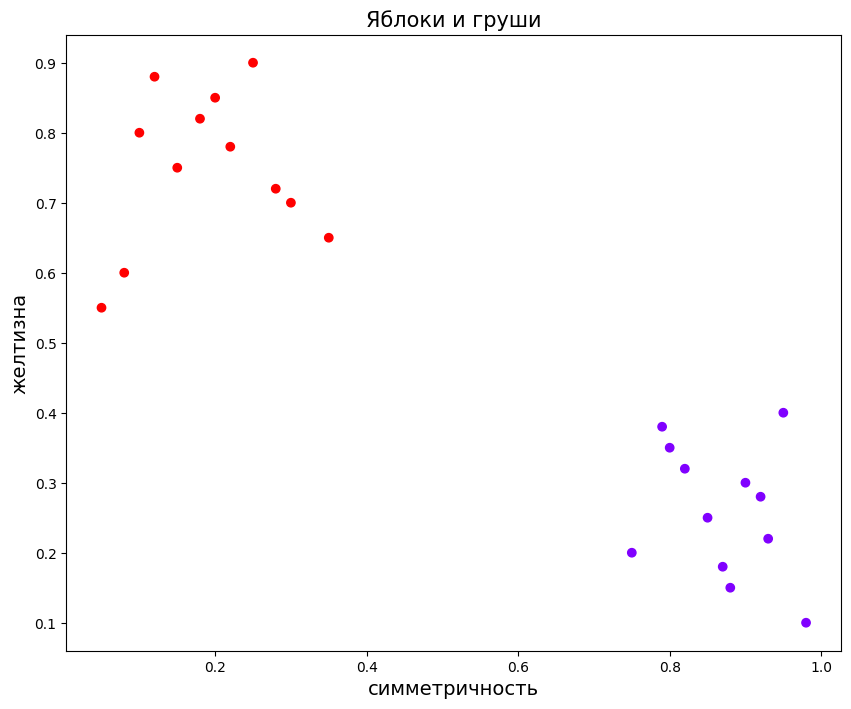

In [10]:
plt.figure(figsize=(10, 8))
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=data['target'], cmap='rainbow')
plt.title('Яблоки и груши', fontsize=15)
plt.xlabel('симметричность', fontsize=14)
plt.ylabel('желтизна', fontsize=14)
plt.show();

Обозначим, что здесь признаки, а что - классы:

In [11]:
X = data.iloc[:,:2].values  # матрица объекты-признаки
y = data['target'].values.reshape((-1, 1))  # классы (столбец из нулей и единиц)

**Вывод функции потерь**  
Функция потерь должна убывать и в итоге стать близкой к 0

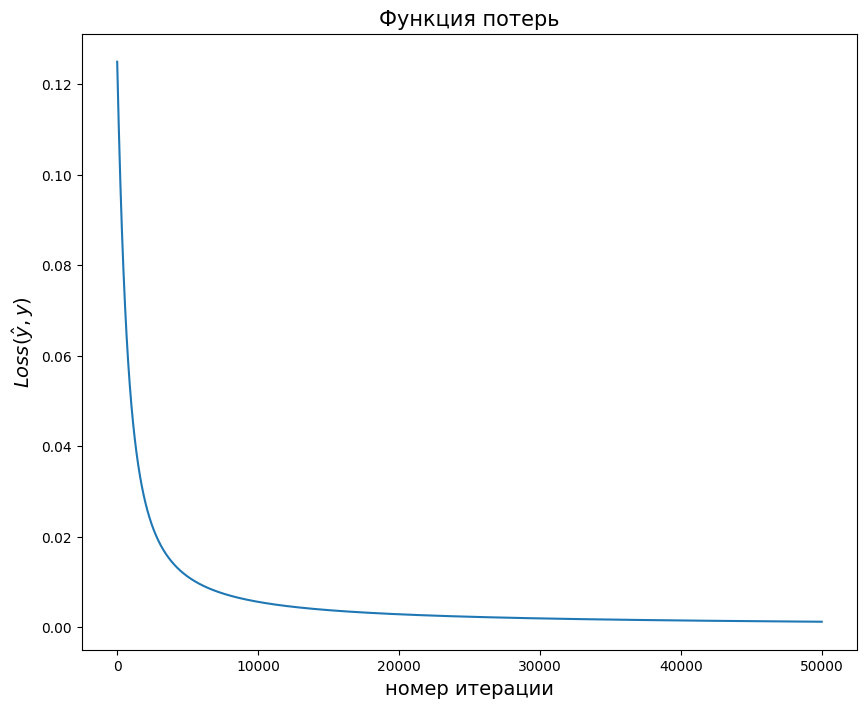

CPU times: user 2.59 s, sys: 8.6 ms, total: 2.6 s
Wall time: 2.62 s


In [12]:
%%time

neuron = Neuron()
Loss_values = neuron.fit(X, y)

plt.figure(figsize=(10, 8))
plt.plot(Loss_values)
plt.title('Функция потерь', fontsize=15)
plt.xlabel('номер итерации', fontsize=14)
plt.ylabel('$Loss(\hat{y}, y)$', fontsize=14)
plt.show()

Посмотрим, как нейрон классифицировал объекты из выборки:

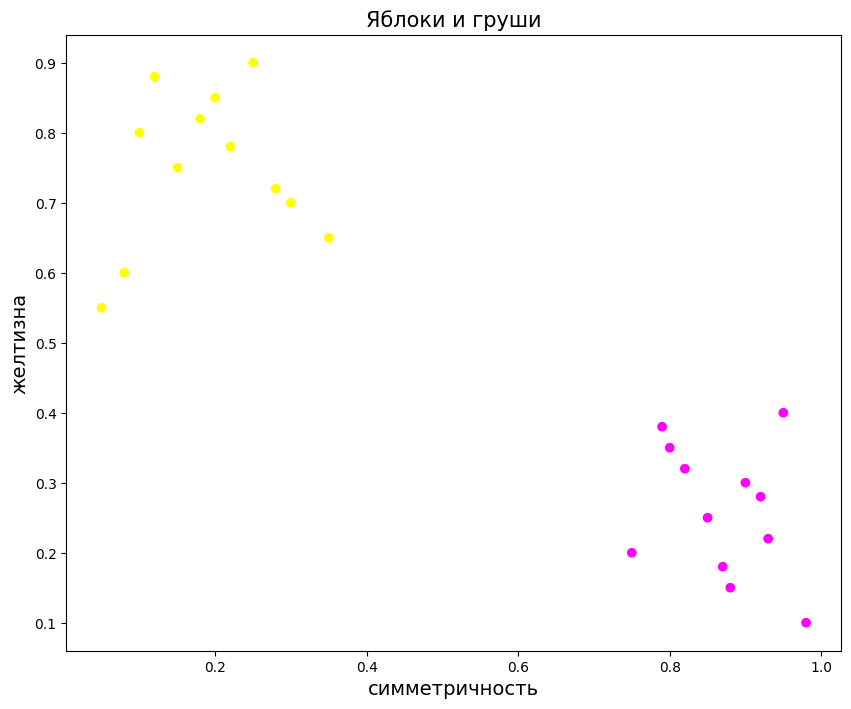

In [13]:
plt.figure(figsize=(10, 8))
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=np.array(neuron.forward_pass(X) > 0.5).ravel(), cmap='spring')
plt.title('Яблоки и груши', fontsize=15)
plt.xlabel('симметричность', fontsize=14)
plt.ylabel('желтизна', fontsize=14)
plt.show();

На этом рисунке мы можем наблюдать плохое качество разделения -- следствие **затухающих градиентов (vanishing gradients)**.

Попробуем увеличить количество итераций градиентного спуска до 50.000 итераций:

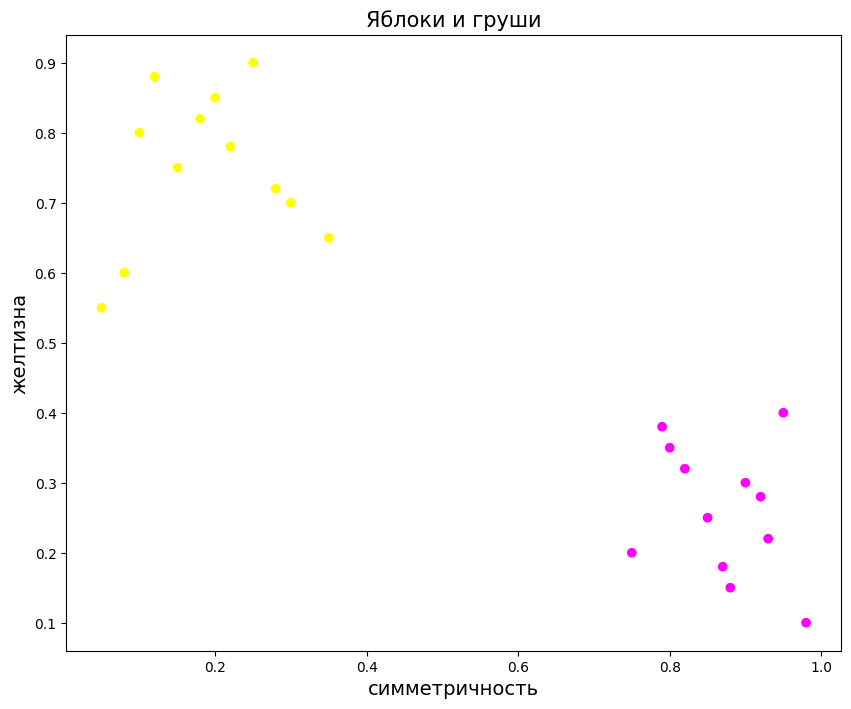

CPU times: user 4.9 s, sys: 10.3 ms, total: 4.91 s
Wall time: 4.99 s


In [14]:
%%time

neuron = Neuron()
loss_values = neuron.fit(X, y, num_epochs=100000)

plt.figure(figsize=(10, 8))
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=np.array(neuron.forward_pass(X) > 0.5).ravel(), cmap='spring')
plt.title('Яблоки и груши', fontsize=15)
plt.xlabel('симметричность', fontsize=14)
plt.ylabel('желтизна', fontsize=14)
plt.show();

Из рисунка видно, что результат стал лучше. Градиенты изменяются медленно, но в правильном направлении и теперь результат разделения улучшился.

Итак, нами было установлено, что **обучение нейрона с сигмоидой с квадратичной функцией потерь**:  

$$MSE(w, x) = \frac{1}{2n}\sum_{i=1}^{n} (\hat{y_i} - y_i)^2 = \frac{1}{2n}\sum_{i=1}^{n} (\sigma(w \cdot x_i) - y_i)^2$$    

где $w \cdot x_i$ - скалярное произведение, а $\sigma(w \cdot x_i) =\frac{1}{1+e^{-w \cdot x_i}} $ - сигмоида -- **неэффективно**, то есть мы увидели, что даже за большое количество итераций (50000 эпох) нейрон предсказывает плохо.

Еще раз взглянем на формулу для градиентного спуска от функции потерь $MSE$ по весам нейрона:

$$ \frac{\partial MSE}{\partial w} = \frac{1}{n} X^T (\sigma(w \cdot X) - y)\sigma(w \cdot X)(1 - \sigma(w \cdot X))$$

Далее проанализируем график сигмоиды:

Если проанализировать формулу функции, то можно заметить, что, поскольку сигмоида принимает значения между 0 и 1 (а значит (1-$\sigma$) тоже принимает значения от 0 до 1), то мы умножаем $X^T$ на столбец $(\sigma(w \cdot X) - y)$ из чисел от -1 до 1, а потом ещё на столбцы $\sigma(w \cdot X)$ и $(1 - \sigma(w \cdot X))$ из чисел от 0 до 1. Таким образом в лучшем случае $\frac{\partial{J}}{\partial{w}}$ будет столбцом из чисел, порядок которых максимум 0.01 (в среднем, понятно, что если сигмоида выдаёт все 0, то будет 0, если все 1, то тоже 0). После этого мы умножаем на шаг градиентного спуска, который обычно порядка 0.001 (не более 0.1). То есть мы вычитаем из весов числа порядка ~0.0001. Это очень медленное изменение значений. Этот факт называют **проблемой затухающих градиентов**.

В задачах классификации, в которых моделью является нейрон с сигмоидной функцией активации, предсказывающий "вероятности" принадлжености к тому или иному классу, почти никогда не используют квадратичную функцию потерь $J$. Вместо нее придумали другую функцию потерь -- **LogLoss**:  

$$J(\hat{y}, y) = -\frac{1}{n} \sum_{i=1}^n y_i \log(\hat{y_i}) + (1 - y_i) \log(1 - \hat{y_i}) = -\frac{1}{n} \sum_{i=1}^n y_i \log(\sigma(w \cdot x_i)) + (1 - y_i) \log(1 - \sigma(w \cdot x_i))$$

где, как и прежде, $y$ - столбец $(n, 1)$ из истинных значений классов, а $\hat{y}$ - столбец $(n, 1)$ из предсказаний нейрона.

In [16]:
def loss(y_pred, y):      #задаем функцию потерь
    return -np.mean(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))

В данный момент рассматривается **бинарная классификация (на два класса)**, в многоклассовой классификации используется функция потерь под названием *кросс-энтропия*, которая является обобщением LogLoss'а на случай нескольких классов.

Ранее была обнаружена проблема умножения маленьких чисел в градиенте. Теперь в этот процесс будут внесены слудующие изменения:

* Для веса $w_j$:

$$ \frac{\partial Loss}{\partial w_j} = 
-\frac{1}{n} \sum_{i=1}^n \left(\frac{y_i}{\sigma(w \cdot x_i)} - \frac{1 - y_i}{1 - \sigma(w \cdot x_i)}\right)(\sigma(w \cdot x_i))_{w_j}' = -\frac{1}{n} \sum_{i=1}^n \left(\frac{y_i}{\sigma(w \cdot x_i)} - \frac{1 - y_i}{1 - \sigma(w \cdot x_i)}\right)\sigma(w \cdot x_i)(1 - \sigma(w \cdot x_i))x_{ij} = $$
$$-\frac{1}{n} \sum_{i=1}^n \left(y_i - \sigma(w \cdot x_i)\right)x_{ij}$$

* Градиент $Loss$'а по вектору весов - это вектор, $j$-ая компонента которого равна $\frac{\partial Loss}{\partial w_j}$ (помним, что весов всего $m$):

$$\begin{align}
    \frac{\partial Loss}{\partial w} &= \begin{bmatrix}
           -\frac{1}{n} \sum_{i=1}^n \left(y_i - \sigma(w \cdot x_i)\right)x_{i1} \\
           -\frac{1}{n} \sum_{i=1}^n \left(y_i - \sigma(w \cdot x_i)\right)x_{i2} \\
           \vdots \\
           -\frac{1}{n} \sum_{i=1}^n \left(y_i - \sigma(w \cdot x_i)\right)x_{im}
         \end{bmatrix}
\end{align}=\frac{1}{n} X^T \left(\hat{y} - y\right)$$

По аналогии с $w_j$ выведите формулу для свободного члена (bias'а) $b$ (*hint*: можно считать, что при нём есть признак $x_{i0}=1$ на всех $i$):

$$ \frac{\partial Loss}{\partial b} = 
-\frac{1}{n} \sum_{i=1}^n \left(\frac{y_i}{\sigma(w \cdot x_i + b)} - \frac{1 - y_i}{1 - \sigma(w \cdot x_i + b)}\right)(\sigma(w \cdot x_i + b))_{b}' = -\frac{1}{n} \sum_{i=1}^n \left(\frac{y_i}{\sigma(w \cdot x_i + b)} - \frac{1 - y_i}{1 - \sigma(w \cdot x_i + b)}\right)\sigma(w \cdot x_i + b)(1 - \sigma(w \cdot x_i + b))*1 = $$
$$-\frac{1}{n} \sum_{i=1}^n \left(y_i - \sigma(w \cdot x_i)\right)$$

Получили новое правило для обновления $w$ и $b$. Заметим, что это в точности то правило обновления весов для градиентного спуска, которое мы использовали для перцептрона. Получается, что мы пришли к этому правилу естественным образом, сделав функцией активации сигмоиду и введя новую функию потерь -- LogLoss, а когда реализовывали перцептрон, мы просто сказали, что $f'(x)$ возьмём единицей, то есть тут имеет место интересная связь градиентного спуска и метода коррекции ошибки.

Отсюда очевидно, что код для нейрона с такой функцией потерь не будет ничем отличаться от кода для перцептрона, за исключением метода `self.activate()`. Напишем:

In [17]:
def sigmoid(x):
    """Сигмоидальная функция"""
    return 1 / (1 + np.exp(-x))

Далее реализуйте нейрон с функцией потерь LogLoss...